In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense
from keras.preprocessing import image as kerasImage
from PIL import Image, ImageEnhance
from scipy.ndimage.filters import gaussian_filter, median_filter
%matplotlib inline
import matplotlib.pyplot as plt
import keras.backend as K
import imageio
import subprocess
import numpy as np
import os

Using TensorFlow backend.


In [2]:
# -- DEFINE FUNCTIONS -- #
if not os.path.isdir('./Results/IntGrad'):
    os.mkdir('./Results/IntGrad')
    
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def deprocess_image(x):    
    x -= x.mean(); x /= (x.std() + K.epsilon()); x*= 0.25
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

def visualize_heatmap(image,heatmap,sinImg,savePath):
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(131)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Integrated Gradients')
    plt.axis('off')
    plt.imshow(heatmap,cmap='bone',interpolation='bilinear')
    plt.subplot(133)
    plt.title('Gradient')
    plt.axis('off')
    plt.imshow(deprocess_image(sinImg.copy()),cmap='bone',interpolation='bilinear')
    fig.savefig(savePath,dpi=250)

In [3]:
model = VGG16(weights='imagenet',include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# -- GET MODEL INFO -- #
inputData = model.inputs[0]
outputLayer = model.get_layer('block5_conv3')
loss = K.mean(outputLayer.output)
gradients = K.gradients(loss, inputData)[0]
intgrad = K.function([inputData], [gradients])

In [5]:
# -- INPUT IMAGE -- #
selImg = input('Select the test image: ')
imgData = load_image('./Data/images/'+selImg+'.jpg',preprocess=False)

Select the test image:  test_56


In [6]:
# -- PREPROCESSING -- #
interY = np.linspace(0.0,1.0,num=50)
lum = ImageEnhance.Brightness(imgData)
imgArray = []
for k in range(50):  
    rgbImg = lum.enhance(interY[k])
    imgArray.append(rgbImg)

In [7]:
# -- FINDING BASELINE AND LIMIT POINT -- #
backImg = kerasImage.img_to_array(imgData)
backImg = np.expand_dims(backImg,axis=0)
backImg = preprocess_input(backImg)
fullPred = model.predict(backImg)
maxClass = np.argsort(fullPred)[0][-1:][::-1]
imgInputArray = []
predictions = []
for k in range(50):
    imgInput = kerasImage.img_to_array(imgArray[k])
    imgInput = np.expand_dims(imgInput,axis=0)
    imgInput = preprocess_input(imgInput)
    imgInputArray.append(imgInput)
    pred = model.predict(imgInput)
    predictions.append(pred[0][maxClass][0])

In [8]:
print(predictions)
maxBase = np.max(np.array(predictions))*0.9
minBase = np.max(np.array(predictions))*0.1
print('-----')
print(minBase,maxBase)
print('-----')
baseline = [n for n,i in enumerate(predictions) if i>minBase][0]
limit = [n for n,i in enumerate(predictions) if i>maxBase][0]
print(interY[baseline],interY[limit])

[0.0003563536, 6.757614e-05, 0.00984787, 0.4050981, 0.7095549, 0.85262483, 0.9114127, 0.9440336, 0.96228725, 0.9700332, 0.9769234, 0.97879696, 0.97999865, 0.9811844, 0.98063654, 0.980977, 0.9808286, 0.9809529, 0.9805848, 0.980166, 0.9799172, 0.9790826, 0.9784736, 0.97839224, 0.9775898, 0.97789073, 0.97750914, 0.97809416, 0.97799385, 0.97794, 0.97743535, 0.9774994, 0.9773582, 0.9772883, 0.9771987, 0.977206, 0.9765446, 0.9760701, 0.97642696, 0.97634125, 0.97722423, 0.97803956, 0.9790829, 0.979215, 0.9801308, 0.98123634, 0.98201066, 0.98284733, 0.98382866, 0.9848156]
-----
0.09848155975341798 0.8863340377807617
-----
0.061224489795918366 0.12244897959183673


In [9]:
# -- REPRESENTATION -- #
samples = int(input('Select the number of luminance samples: '))
interX = np.linspace(interY[baseline],interY[limit],num=samples)
lum = ImageEnhance.Brightness(imgData)
imgArray = []
for k in range(samples):  
    rgbImg = lum.enhance(interX[k])
    imgArray.append(rgbImg)
IntGrad = []
for k in range(samples):
    imgInput = kerasImage.img_to_array(imgArray[k])
    imgInput = np.expand_dims(imgInput,axis=0)
    gradVal = intgrad([imgInput])[0]
    IntGrad.append(gradVal)
print('DONE')

Select the number of luminance samples:  50


DONE


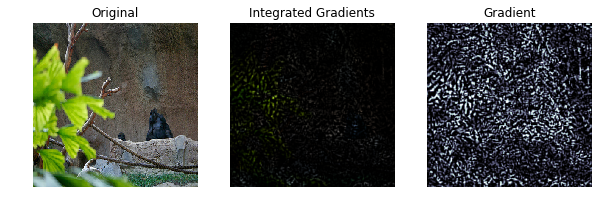

In [10]:
heatMap = np.mean(np.array(IntGrad),axis=0)
heatMap[heatMap < np.mean(heatMap,axis=0)] = 0
heatMap = np.sum(heatMap[0],axis=-1)
heatMap[heatMap < np.mean(heatMap)] = 0
sinImg = np.sum(intgrad([backImg])[0],axis=-1)
sinImg[sinImg < np.mean(sinImg)] = 0
savePath = './Results/IntGrad/'+selImg+'.png'
# -- VISUALIZE INTGRADIENTS -- #
mask = np.zeros(backImg.shape)
IntGradNorm = (heatMap - np.min(heatMap))/(np.max(heatMap)-np.min(heatMap))
mask[0,:,:,0] = IntGradNorm; mask[0,:,:,1] = IntGradNorm; mask[0,:,:,2] = IntGradNorm
IntGradImg = backImg[0]*mask
IntGradImg = kerasImage.array_to_img(IntGradImg[0])
visualize_heatmap(imgData,IntGradImg,sinImg[0],savePath)

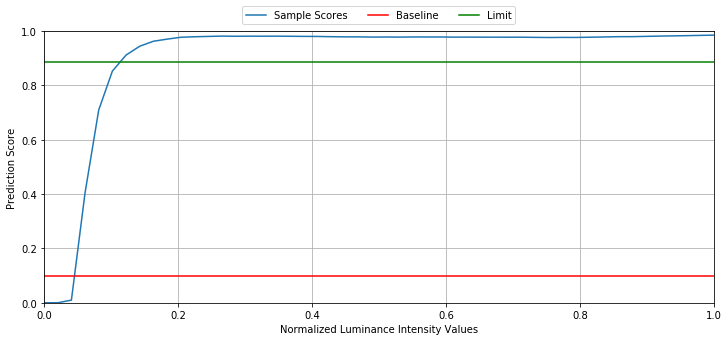

In [15]:
fig = plt.figure(figsize=(12, 5))
plt.plot(interY,predictions)
plt.axhline(y=minBase, color='r', linestyle='-')
plt.axhline(y=maxBase, color='g', linestyle='-')
plt.xlabel('Normalized Luminance Intensity Values')
plt.ylabel('Prediction Score')
plt.grid(True)
plt.legend(['Sample Scores','Baseline','Limit'],bbox_to_anchor=(0., 1.025, 1., 0.102), loc=8,
           ncol=3, mode="center", borderaxespad=0.)
plt.axis([0.0, 1.0, 0.0, 1.0])
plt.show()
fig.savefig('./Results/IntGrad/int_graph.png',dpi=250)